In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from data.SimLVSeg.simlvseg.utils import load_video, save_video
from data.SimLVSeg.simlvseg.seg_3d.pl_module import Seg3DModule
import os
import torch

from tqdm import tqdm
from torch.utils.data import DataLoader
from data.SimLVSeg.simlvseg.utils import set_seed, save_video
from data.SimLVSeg.simlvseg.seg_3d.preprocessing import get_preprocessing_for_training
from utils import InferenceDataset



# Data augmentation pipeline

In [ ]:
# Paths
video_dir = "/home/hc4293/echoframe/data/echodynamic/Videos/"
save_dir = "/home/hc4293/echoframe/data/echodynamic/augmented_masks/"
checkpoint_path = "/home/hc4293/echoframe/data/echodynamic/checkpoints/epoch=25-step=23999.ckpt"
os.makedirs(save_dir, exist_ok=True)

# Normalization parameters
mean = [0.12741163, 0.1279413, 0.12912785]
std = [0.19557191, 0.19562256, 0.1965878]

# Model and inference parameters
frames = 32
period = 1
batch_size = 16
num_workers = 4
seed = 42

# Set random seed
set_seed(seed)

# Load the model
model = Seg3DModule.load_from_checkpoint(checkpoint_path, encoder_name="3d_unet")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Preprocessing for the model
preprocessing = get_preprocessing_for_training(frames, mean, std)

# Iterate over all videos in the directory
for video_file in os.listdir(video_dir):
    if video_file.endswith(".avi"):
        video_path = os.path.join(video_dir, video_file)
        save_path = os.path.join(save_dir, os.path.splitext(video_file)[0])  # Save as .pt

        try:
            # Create dataset and dataloader
            dataset = InferenceDataset(video_path, frames, period, preprocessing)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, drop_last=False)

            # Prepare the output tensor storage
            video_tensor = np.zeros_like(dataset.video[0], dtype=np.uint8)

            # Perform inference
            with torch.no_grad():
                for data in tqdm(dataloader, desc=f"Processing {video_file}"):
                    inputs, frame_indexes = data
                    outs = model(inputs.to(device))

                    # Process batch predictions
                    batch_preds = outs.detach().cpu().numpy()
                    batch_preds = batch_preds[:, 0]
                    batch_preds[batch_preds >= 0] = 255
                    batch_preds[batch_preds < 0] = 0
                    batch_preds = batch_preds.astype(np.uint8)

                    # Save predictions to tensor
                    for preds, indexes in zip(batch_preds, frame_indexes):
                        preds = preds.transpose(2, 0, 1)
                        video_tensor[indexes] = preds.copy()

            # Save the segmented tensor
            torch.save(torch.tensor(video_tensor), save_path)
            print(f"Segmented tensor saved at: {save_path}")

        except Exception as e:
            print(f"Error processing {video_file}: {e}")


# Evaluate

Original Video Properties:
 - Number of Frames: 221
 - Resolution: 112x112

Loading PyTorch tensor from: /home/hc4293/echoframe/data/echodynamic/augmented_masks/0XF6661AF354401A5
Loaded PyTorch tensor successfully!

Processed Video Properties:
 - Number of Frames: 221
 - Resolution: 112x112

Sample frame pixel values:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Number of frames to plot: 221


/tmp/ipykernel_2390424/4085731835.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  video_tensor = torch.load(file_path)


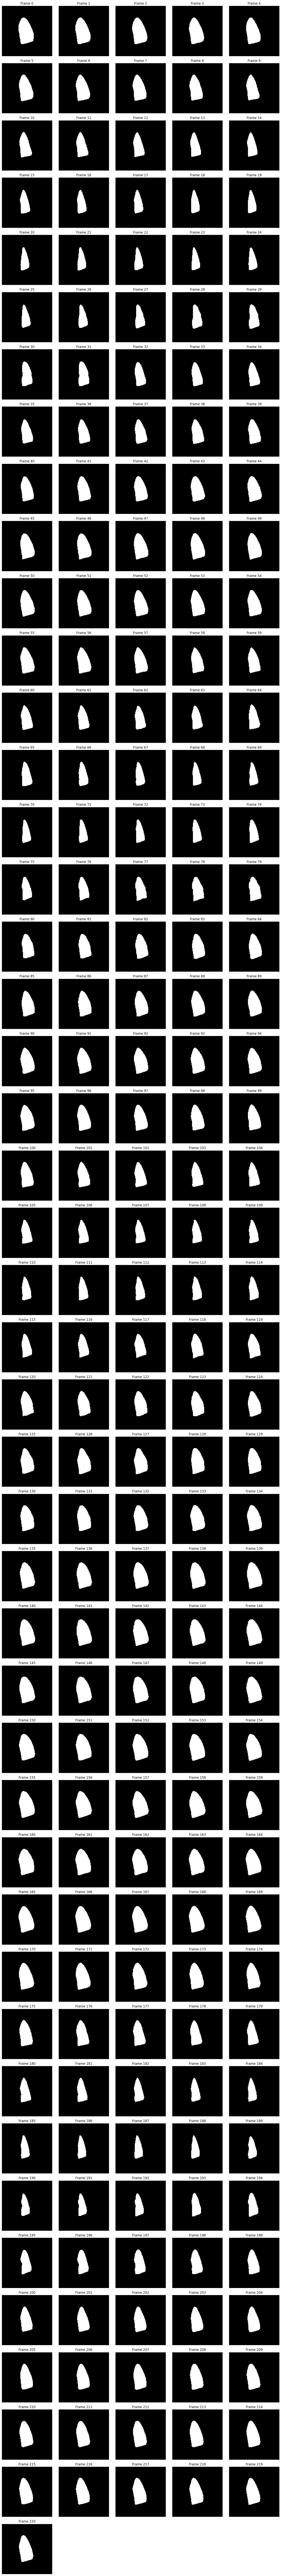

All frames have been plotted successfully!


In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

# Function to load the video tensor
def load_video_tensor(file_path):

    print(f"Loading PyTorch tensor from: {file_path}")
    video_tensor = torch.load(file_path)
    print("Loaded PyTorch tensor successfully!")
    return video_tensor.numpy()

# Function to get original video properties
def get_video_properties(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Could not open video file: {video_path}")
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return total_frames, width, height

# Original video path
original_video_path = "/home/hc4293/echoframe/data/echodynamic/Videos/0XF6661AF354401A5.avi"

# Get properties of the original video
original_frame_count, original_width, original_height = get_video_properties(original_video_path)

# Print original video properties
print(f"Original Video Properties:\n"
      f" - Number of Frames: {original_frame_count}\n"
      f" - Resolution: {original_width}x{original_height}\n")

# Path to the saved video tensor
tensor_file_path = "/home/hc4293/echoframe/data/echodynamic/augmented_masks/0XF6661AF354401A5"

# Load the video tensor
video = load_video_tensor(tensor_file_path)

# Processed video properties
processed_frame_count = video.shape[0]
processed_height, processed_width = video.shape[1], video.shape[2]

# Print processed video properties
print(f"\nProcessed Video Properties:\n"
      f" - Number of Frames: {processed_frame_count}\n"
      f" - Resolution: {processed_width}x{processed_height}\n")

# Print a sample frame for confirmation
print("Sample frame pixel values:")
print(video[0])

# Plot the frames in a grid layout
# Number of frames in the video
num_frames = len(video)

# Print the number of frames being plotted
print(f"\nNumber of frames to plot: {num_frames}")

# Set up grid dimensions
cols = 5  # Number of columns
rows = math.ceil(num_frames / cols)  # Calculate rows based on number of frames

# Create the grid plot
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each frame
for i in range(num_frames):
    axes[i].imshow(video[i], cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Frame {i}")

# Turn off unused grid cells
for i in range(num_frames, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print("All frames have been plotted successfully!")
